# Dataset Statistics
<br> ------------------------------------------------------------------------
<br> This Notebook shows different dataset statistics of the Lyft 
<br> Lvl 5 dataset.
<br>
<br> tl2la
<br> Copyright (c) 2023 Andreas Weber. All Rights Reserved.
<br> ------------------------------------------------------------------------
<br> Modified from L5Kit (https://github.com/woven-planet/l5kit)
<br> Copyright (c) 2022 Woven by Toyota. All Rights Reserved.
<br> ------------------------------------------------------------------------

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import itertools
import plotly.express as px
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from datetime import time
from matplotlib.ticker import FuncFormatter
from prettytable import PrettyTable
from tqdm import tqdm

from l5kit.data import PERCEPTION_LABELS
from l5kit.data import ChunkedDataset

from src.dataset_operations.extended_map_api import ExtendedMapAPI
from src.dataset_operations.junction_dataset import JunctionDataset
from src.common.helper import init_dataset, load_pickled_df
from src.visualization.map_renderer import StaticMapRenderer
from src.dataset_operations.branch_dataset import DATASET_TYPE


sns.set_style("darkgrid")
sns.set_palette("Set1")
pd.options.plotting.backend = "plotly"

## Load Datasets

In [4]:
cfg_train1, dm_train1, train1_dataset = init_dataset("train1")
cfg_trainfull, dm_trainfull, trainfull_dataset = init_dataset("trainfull")
cfg_intro, dm_intro, intro_dataset = init_dataset("intro")

## Distirbution of Scenes over Dates and Time

In [7]:
def count_days(dataset: ChunkedDataset, name: str) -> pd.Series:
    timestamps: list = dataset.scenes["start_time"]
    dates: np.ndarray = np.array(
        [ts.astype('datetime64[ns]') for ts in timestamps])
    dates_df: pd.DataFrame = pd.DataFrame(dates, columns=[f"date_{name}"])
    days_count: pd.Series = dates_df.groupby(dates_df[f'date_{name}'].dt.date)[
        f'date_{name}'].count()
    return days_count


intro_count = count_days(intro_dataset, "intro")
train1_count = count_days(train1_dataset, "train1")
trainfull_count = count_days(trainfull_dataset, "train_full")

merged1 = pd.merge(trainfull_count, train1_count,
                   right_index=True, left_index=True, how="left")
merged2 = pd.merge(merged1, intro_count,
                   right_index=True, left_index=True, how="left")


fig = px.bar(merged2, title="Distribution of scenes over Dates", labels={'index': 'Date', 'value':'Number of Scenes'})
fig.write_html("./res/analysis/dynamic_data/date.html")
fig.show()


### Time Distribution

In [9]:
def count_time(dataset: ChunkedDataset, name: str) -> pd.Series:
    timestamps: list = dataset.scenes["start_time"]
    dates: np.ndarray = np.array(
        [ts.astype('datetime64[ns]') for ts in timestamps])
    dates_df: pd.DataFrame = pd.DataFrame(dates, columns=[f"time_{name}"])

    dates_df[f"time_{name}"] = dates_df[f"time_{name}"].apply(lambda x: time(
        hour=((x.hour+24-7) % 24)))
    days_count: pd.Series = dates_df.groupby(dates_df[f'time_{name}'])[
        f'time_{name}'].count()
    return days_count

intro_count = count_time(intro_dataset, "intro")
train1_count = count_time(train1_dataset, "train1")
trainfull_count = count_time(trainfull_dataset, "train_full")

merged1 = pd.merge(trainfull_count, train1_count,
                   right_index=True, left_index=True, how="left")
merged2 = pd.merge(merged1, intro_count,
                   right_index=True, left_index=True, how="left")

fig = px.bar(merged2,
             title="Distribution of scenes over Time",
             labels={'index': f'Time', 'value':'Number of Scenes'}
             )
fig.write_html("./res/analysis/dynamic_data/date.html")
fig.show()

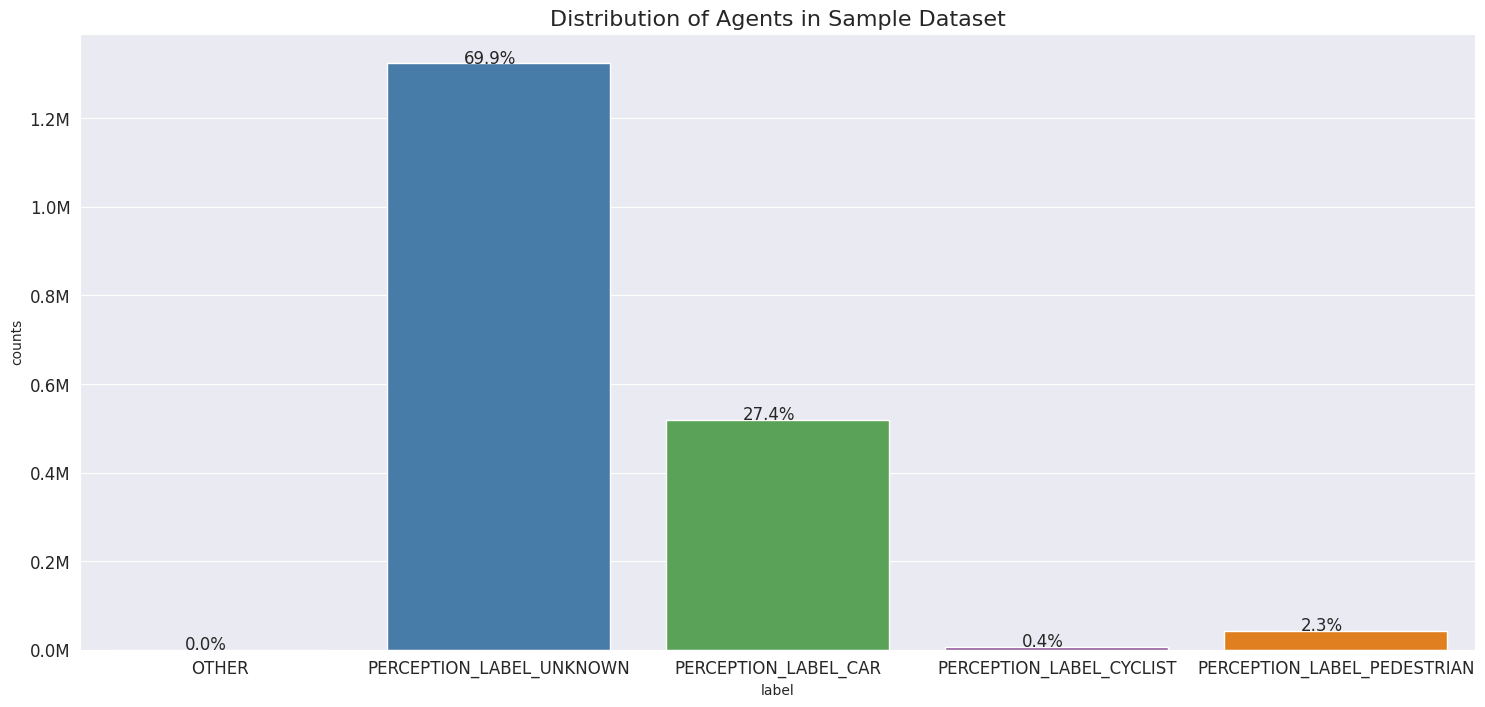

In [16]:
# cfg_sample, dm_sample, sample_dataset = init_dataset("intro") # can be done for other datasets as well

agents = intro_dataset.agents
agents_types = agents.dtype.names

probabilities = agents["label_probabilities"]
labels_indexes = np.argmax(probabilities, axis=1)
counts = []

# for idx_label, label in enumerate(tqdm(PERCEPTION_LABELS, desc="getting centroid to plot trajectory")):
for idx_label, label in enumerate(PERCEPTION_LABELS):
    counts.append(np.sum(labels_indexes == idx_label))

field_names = ["label", "counts"]
table = PrettyTable(field_names=field_names)
agent_distribution_df = pd.DataFrame(columns=field_names)
for label, count in zip(PERCEPTION_LABELS, counts):
    row_to_append = [label, count]
    table.add_row(row_to_append)
    agent_distribution_df.loc[len(agent_distribution_df)] = row_to_append

adjusted_agent_distribution_df = agent_distribution_df.copy()
adjusted_agent_distribution_df.loc[adjusted_agent_distribution_df["counts"] == 0, "label"] = "OTHER"


def without_hue(ax, total):
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.125
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size=12)


def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)


plt.figure(figsize=(18, 8))
sns.barplot(y="counts", x="label", data=adjusted_agent_distribution_df)

formatter = FuncFormatter(millions)
plt.gca().yaxis.set_major_formatter(formatter)
without_hue(plt.gca(), agent_distribution_df["counts"].sum())
plt.title("Distribution of Agents in Sample Dataset", fontsize=16)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.savefig("./res/analysis/dynamic_data/distribution_agents_sample.png")

## Show Distribution of Traffic Light Scenes

In [17]:
def filter_tfl_scenes(zarr_dataset: ChunkedDataset) -> list:
    scene_idxs_with_tfls = []

    for scene_idx in tqdm(range(len(zarr_dataset.scenes)), desc="Iterate through scenes to get scene idxs with tfls"):
        current_scene = zarr_dataset.get_scene_dataset(scene_index=scene_idx)

        # add scenes with tfls
        if len(current_scene.tl_faces) > 0:
            scene_idxs_with_tfls.append(scene_idx)

    return scene_idxs_with_tfls

In [18]:
# Execute for filtering tl_scenes
"""

tls_scene_idxs = filter_tfl_scenes(trainfull_dataset)
with open('./dataset/preprocessed_info/tls_scene_indices_trainfull.pkl', 'wb') as f:
    pickle.dump(tls_scene_idxs, f)

"""


# Otherwise if preprocessed read tl_indices
with open('./dataset/preprocessed_info/tls_scene_indices_trainfull.pkl', 'rb') as f:
    tls_scene_idxs = pickle.load(f)

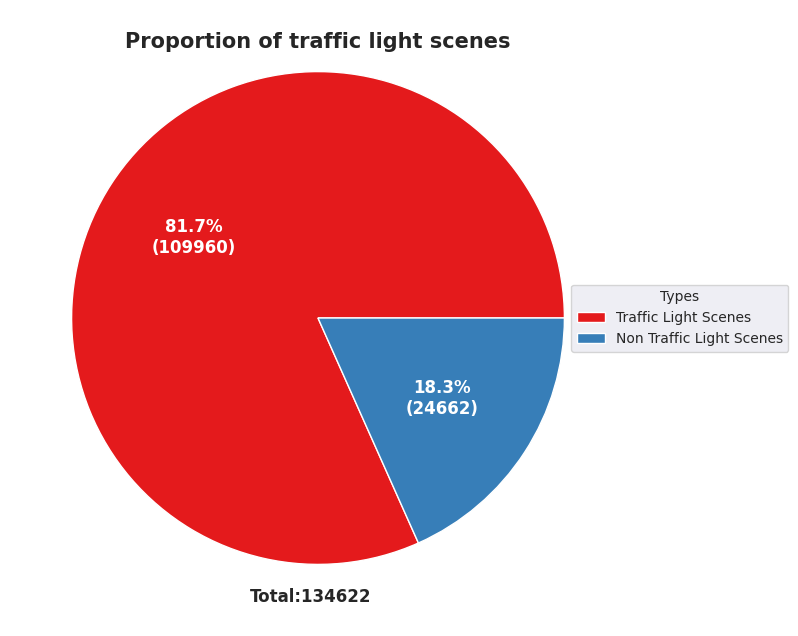

In [20]:
num_scenes_with_tfls = len(tls_scene_idxs)
num_scenes_total = len(trainfull_dataset.scenes)
num_scenes_without_tfls = num_scenes_total - len(tls_scene_idxs)
tfl_dist_data = [num_scenes_with_tfls, num_scenes_without_tfls]
tfl_dist_labels = ["Traffic Light Scenes", "Non Traffic Light Scenes"]

# %%
fig, ax = plt.subplots(figsize=(16, 8), subplot_kw=dict(aspect="equal"))


def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:d})".format(pct, absolute)


wedges, texts, autotexts = ax.pie(tfl_dist_data, autopct=lambda pct: func(pct, tfl_dist_data),
                                  textprops=dict(color="w"))
ax.legend(wedges, tfl_dist_labels,
          title="Types",
          loc="center left",
          bbox_to_anchor=(0.9, 0, 0.5, 1))
plt.setp(autotexts, size=12, weight="bold")
ax.set_title("Proportion of traffic light scenes", size=15, weight="bold", y=0.925)
plt.figtext(0.47, 0.14, f'Total:{num_scenes_total}',
            fontsize=12, weight="bold")
plt.show()

## Analyse Traffic Control Elements

### Generate MapAPI and JunctionDataset Object

In [9]:
mapAPI = ExtendedMapAPI.from_config(dm_trainfull, cfg_trainfull)
junctionDataset = JunctionDataset(cfg_trainfull, mapAPI, trainfull_dataset)

### Basic Visualisation of Semantic Map

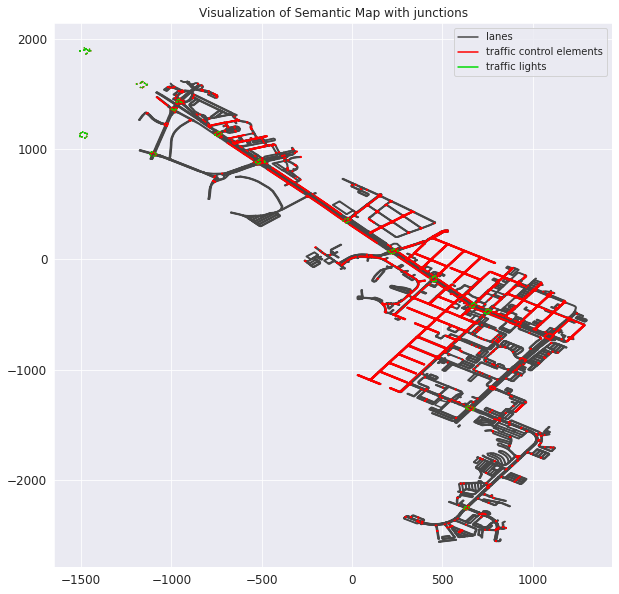

In [10]:
# Show Map
renderer = StaticMapRenderer(mapAPI)
fig, ax = renderer.render_lanes()  # grey

# red: all trafic control elements
fig, ax = renderer.render_traffic_control_elements()
fig, ax = renderer.render_traffic_lights()  # green: trafic lights
# fig, ax = renderer.render_junctions()  # orange: junctions

# Styling
lgd_lane = mlines.Line2D([0], [0], color='#474747', label="lanes")
lgd_tfe = mlines.Line2D([0], [0], color='#ff0000', label="traffic control elements")
lgd_tfl = mlines.Line2D([0], [0], color='#00db04', label="traffic lights")
lgd_junctions = mlines.Line2D([0], [0], color='#fcba03', label="junctions")

plt.legend(handles=[lgd_lane, 
                    lgd_tfe, 
                    lgd_tfl, 
                    # lgd_junctions
                    ])
plt.title("Visualization of Semantic Map with junctions")
plt.show()

### Traffic Lights

In [11]:
# Number of traffic lights
tl_ids = mapAPI.get_tl_bounds()["ids"]
print(f"Number of traffic lights: {len(tl_ids)}")

Number of traffic lights: 211


In [12]:
# Number of traffic lights with relations to lanes 
tl_with_lane_relations = len(junctionDataset.tl_lane_relations.keys())
print(f"Number of traffic light with relations to lanes: {tl_with_lane_relations}")

Number of traffic light with relations to lanes: 96


In [13]:
# Number of traffic lights with relations to lane segments 
lane_segments = junctionDataset.tl_lane_relations.values()
lane_segments = [list(lane_segment_set) for lane_segment_set in lane_segments]
lane_segments_unpacked = list(itertools.chain.from_iterable(lane_segments))
print(f"Number of traffic light to lane segment relations: {len(lane_segments_unpacked)}")

Number of traffic light to lane segment relations: 567


The number of  lane to map segment relations is 567. This can be reasoned because in the semantic map the relation of a traffic light to a lane or more precise to segments of a lane consists of two relations. The relation to
 - The segment in front of the intersection
 - The segment inside the intersection

Since the lane segments belong to the same lane, the relation between the individual segments and traffic light can be summarized to one relation.


In [15]:
# Number of traffic lights with relations to lanes
count = 0
for lane_id in junctionDataset.lane_tl_relations:
    corresponding_tl_ids = junctionDataset.lane_tl_relations[lane_id]

    predeccor_lanes = mapAPI.get_lane_predecessors(lane_id)
    has_predecessor = any(predecessor in junctionDataset.lane_tl_relations.keys()
                            for predecessor in predeccor_lanes)
    if has_predecessor:
        continue
    count += len(corresponding_tl_ids)

print(f"Number of traffic light to lane relations: {count}")

Number of traffic light to lane relations: 230


In [16]:
print(f"there are {count} lane relations → in avg. {round(count/tl_with_lane_relations, 2)} lane relations per traffic light")

there are 230 lane relations → in avg. 2.4 lane relations per traffic light


## Visualize Distribution of Scenes over Traffic Light Junctions 

In [17]:
pd.options.plotting.backend = "matplotlib"

In [18]:
# helper function
def find_elements_of_A_not_in_B(a: list, b: list) -> list:
    return [el for el in a if el not in b]

In [19]:
preprocessed_data_path = "./dataset/preprocessed_info/extended_junction_branch_to_lane.csv"
branches_df = pd.read_csv(preprocessed_data_path, encoding="ascii")

In [20]:
# Load Preprocessed Dataframe with agent to lane mapping for every frame of every scene in trainfull dataset
with open('./dataset/preprocessed_info/frame_lane_df_trainfull.pkl', 'rb') as f:
    frame_lane_df = pickle.load(f)


In [21]:
# Merge Agent to lane Mapping and Junction Branch Dataset 
merged_df = frame_lane_df.join(
    branches_df.set_index('lane_id'), on=['lane_id'])
merged_df = merged_df.fillna("unknown")
merged_df.groupby(['scene_idx', 'junction_id']).size()

scene_idx  junction_id
1          unknown        287
           y4Ss            88
2          y4Ss           249
3          y4Ss           249
4          y4Ss           249
                         ... 
134619     unknown        329
           y4Ss            71
134620     unknown        318
134621     LrDx           150
           unknown        128
Length: 183871, dtype: int64

### Visualize Distribution over Junction IDs

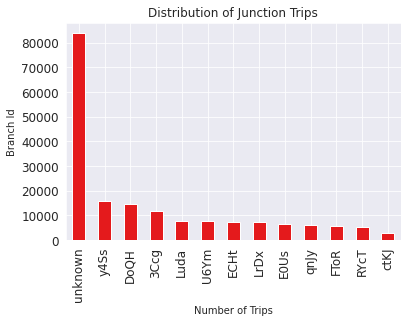

In [23]:
junc_distribution = merged_df.groupby(['scene_idx', 'junction_id']).size().groupby(
    'junction_id').count()
junc_distribution = junc_distribution.sort_values(ascending=False)
junc_distribution.plot.bar( x="Junctions", y="Number of Trips")
plt.title("Distribution of Junction Trips")
plt.xlabel('Number of Trips')
plt.ylabel("Branch Id")
plt.savefig(
    "./res/analysis/dynamic_data/distribution_junction_trips_trainfull.png", bbox_inches='tight')
plt.show()

### Visualize Distribution over Branch IDs

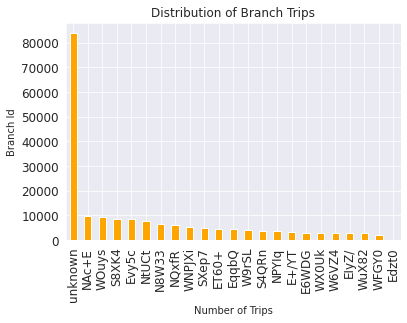

In [24]:
branch_distribution = merged_df.groupby(['scene_idx', 'branch_id']).size().groupby(
    'branch_id').count()
branch_distribution = branch_distribution.sort_values(ascending=False)
branch_distribution.plot.bar(x="Branches", y="Number of Trips",
                             title="Distribution of Branch Trips", color="orange")
plt.xlabel('Number of Trips')
plt.ylabel("Branch Id")
plt.savefig("./res/analysis/dynamic_data/distribution_branch_trips_trainfull.png", bbox_inches='tight')
plt.show()

### Show Distribution per Branch ID over Junctions

/lhome/andrwe/Programming/AFL_6Sem/venv/lib/python3.6/site-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



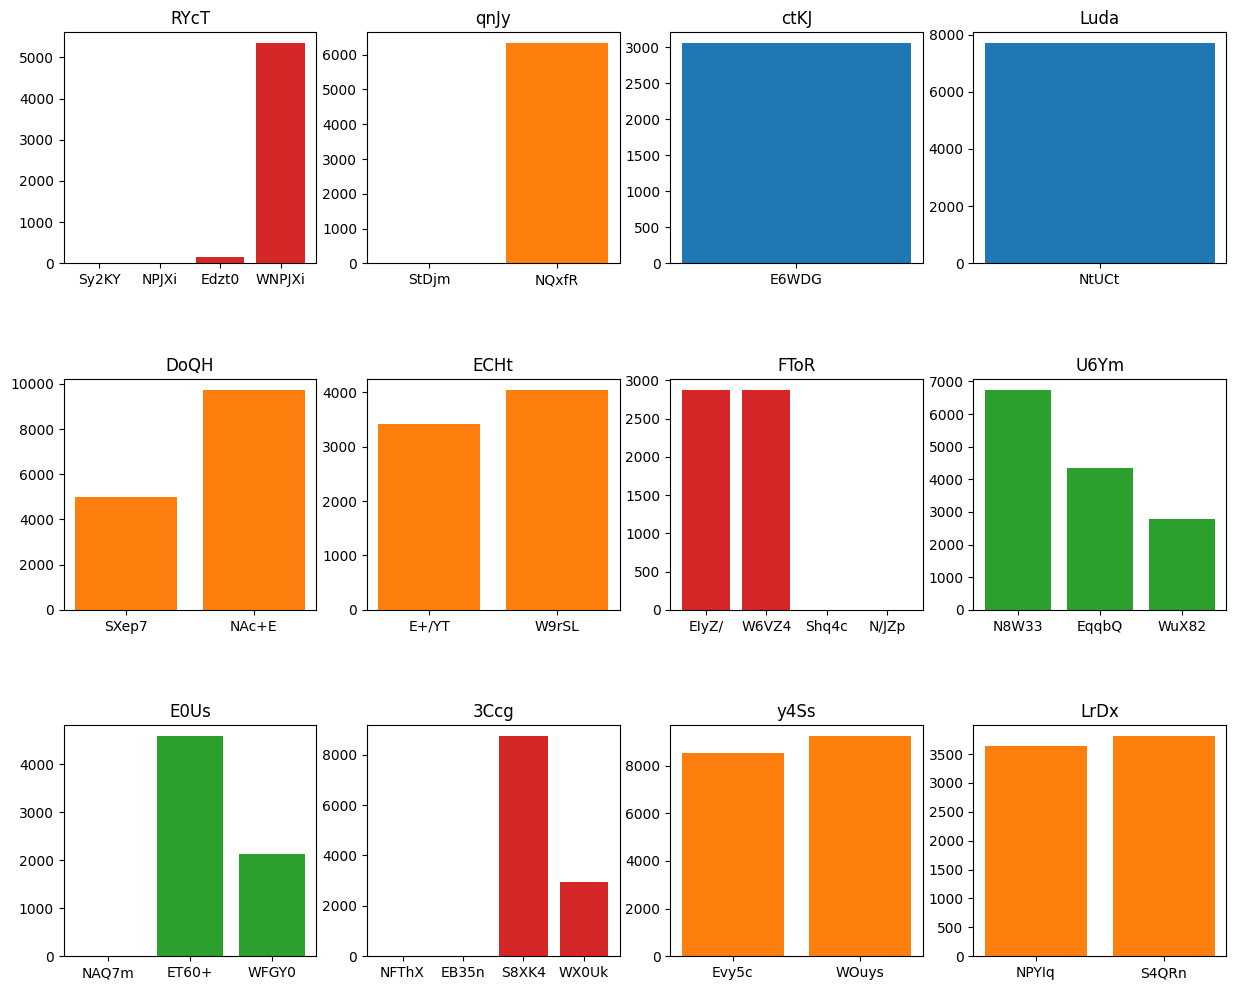

In [44]:
available_junction_ids = merged_df.groupby(['scene_idx', 'junction_id']).size(
).groupby('junction_id').count().index.values.tolist()
tl_junction_ids = branches_df["junction_id"].unique().tolist()
find_elements_of_A_not_in_B(tl_junction_ids, available_junction_ids)
# %%
available_branch_ids = merged_df.groupby(['scene_idx', 'branch_id']).size(
).groupby('branch_id').count().index.values.tolist()
# %%
scene_ids_per_lane = merged_df.groupby("lane_id")["scene_idx"].unique()
driven_lane_ids = merged_df["lane_id"].unique().tolist()
# %%
lane_id_to_scene_ids_df = pd.DataFrame(columns=["lane_id", "scene_indices"])
lane_id_to_scene_ids_df["scene_indices"] = lane_id_to_scene_ids_df["scene_indices"].astype(
    'object')
lane_id_to_scene_ids_df["scene_indices"] = scene_ids_per_lane.values.tolist()
lane_id_to_scene_ids_df["lane_id"] = merged_df["lane_id"].unique().tolist()
lane_id_to_scene_ids_df["trips"] = lane_id_to_scene_ids_df["scene_indices"].apply(
    lambda x: len(x))
# %%
lane_id_to_scene_ids_df["trips"].max()
# %%
plt.style.use('default')
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)

# plt.suptitle(
#     "Branch Trip Distribution for every Traffic Light Junction", fontsize=14, y=0.95)
for i, junction in enumerate(branches_df["junction_id"].unique().tolist()):
    branch_dict = dict()
    branches = branches_df[branches_df["junction_id"]
                           == junction]["branch_id"].unique().tolist()
    for b in branches:
        if b in branch_distribution.index.values.tolist():
            branch_dict[b] = branch_distribution[b]
        else:
            branch_dict[b] = 0

        names = list(branch_dict.keys())
        values = list(branch_dict.values())

        ax = plt.subplot(3, 4, i + 1)
        ax.bar(range(len(branch_dict)), values, tick_label=names)
        ax.set_title(junction, fontsize=12)
        
plt.savefig(
    "./res/analysis/dynamic_data/branch_travel_distribution_per_junction_trainfull.png", bbox_inches='tight')
plt.show()

## Target Associations for Ego Vehicle

In [21]:
pd.options.plotting.backend = "matplotlib"
dataset_type = "trainfull"
cfg, dm, zarr_dataset = init_dataset(config_name=dataset_type)
mapAPI = ExtendedMapAPI.from_config(dm, cfg)
junctionDataset = JunctionDataset(cfg, mapAPI, zarr_dataset)
extended_branch_df = junctionDataset.get_branch_dataset(DATASET_TYPE.EXTENDED)

In [23]:
ego_lane_mapping = load_pickled_df("dataset/preprocessed_info/frame_lane_df_trainfull.pkl")
unique_lane_ids_traveled = ego_lane_mapping["lane_id"].unique()
target_df = junctionDataset.get_ground_truth_corrected()
ego_target_df = target_df[target_df["lane_id"].isin(unique_lane_ids_traveled)]

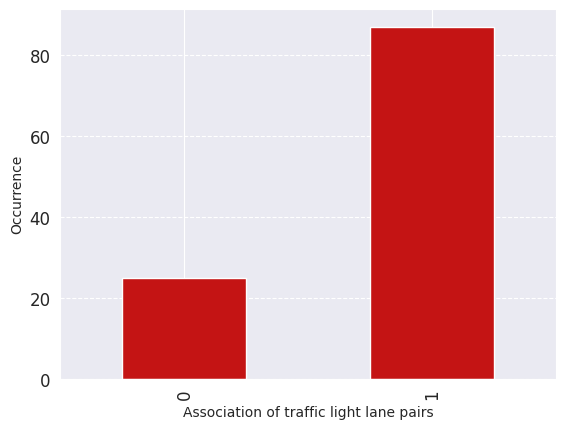

In [24]:
ground_trouth_distribution = ego_target_df.groupby(by="relation", as_index=False).count()
ground_trouth_distribution[["relation", "tl_id"]].plot(kind='bar', x="relation", y="tl_id", legend=False, color=[(196/255, 20/255, 20/255)])
plt.gca().set_axisbelow(True)
plt.grid(axis='y', linestyle='dashed')
plt.ylabel('Occurrence')
plt.xlabel('Association of traffic light lane pairs')
plt.show()